<a href="https://colab.research.google.com/github/hongyuaw/Coursera_Capstone/blob/Master/Capstone_project_(week_5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone project: Battle of Neighborhoods

In [ ]:
#Import all required libraries

import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.7.0 --yes
import folium # map rendering library
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Done!


In [ ]:
# Enter Foursquare Credentials and Version
CLIENT_ID = 'PS5Q5N1L5BIFXX131XPBBRKQSH4K3WI5Z1EHLGLDWFVZTUWD' 
CLIENT_SECRET = 'ZAW1TVTIO2KBKKUL5SJS0DPRHEHURZZZ1PTBWE1QSMYEW4TE' 
VERSION = '20180605'

In [ ]:
# Define key functions for later data outputs

def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=500
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

<b>Part 1: Initial data collection

In [ ]:
# Get the initial list of NYC geo data by borough and neighborhood

ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [ ]:
# Get the number of neighborhoods in NYC
ny_data.shape

(306, 4)

<b>Part 2: Data analysis

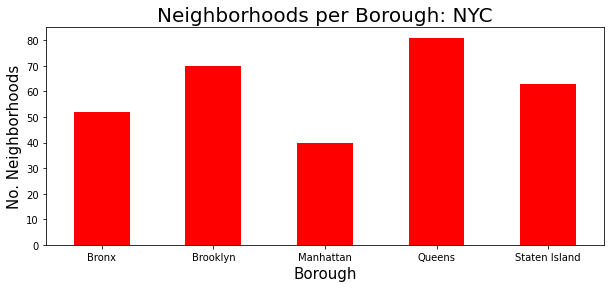

In [ ]:
# Get number of neighborhoods in NYC by Borough and graph it

clr = "red"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,4), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
# Get a new dataset for neighborhood that has Korean restaurants 

column_names=['Borough', 'Neighborhood', 'ID','Name']
korean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    korean_resturants=venues[venues['Category']=='Korean Restaurant']   
    print('(',count,'/',len(ny_data),')','Korean Resturants in '+Neighborhood+', '+Borough+':'+str(len(korean_resturants)))
    print(row)
    for resturant_detail in korean_resturants.values.tolist():
        id, name , category=resturant_detail
        korean_rest_ny = korean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Korean Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Korean Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Korean Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Korean Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Korean Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Korean Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Korean Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Korean Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Korean Resturants in Norwood, Bronx:0
['Bronx', 'Norwood',

( 69 / 306 ) Korean Resturants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Korean Resturants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Korean Resturants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Korean Resturants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Korean Resturants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Korean Resturants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Korean Resturants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269778966]
( 76 / 306 ) Korean Resturants in Flatlands, Brooklyn:0
['Brooklyn', 'Flatlands', 40.630446043757466, -73.92911302644674]
( 77 

( 133 / 306 ) Korean Resturants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Korean Resturants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Korean Resturants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Korean Resturants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Korean Resturants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Korean Resturants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) Korean Resturants in Flushing, Queens:5
['Queens', 'Flushing', 40.76445419697846, -73.83177300329582]
( 140 / 306 ) Korean Resturants in Long Island City, Queens:0
['Queens', 'Long Island City', 40.75021734610528, -73.93920223915505]
( 141 / 306 ) Korean Resturan

( 200 / 306 ) Korean Resturants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Korean Resturants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Korean Resturants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Korean Resturants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Korean Resturants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Korean Resturants in South Beach, Staten Island:0
['Staten Island', 'South Beach', 40.58024741350956, -74.0795529253982]
( 206 / 306 ) Korean Resturants in Port Richmond, Staten Island:0
['Staten Island', 'Port Richmond', 40.63366930554365, -74.12943426797008]
( 207 / 306 ) Korean Resturants in Mariner's Harbor, Sta

( 262 / 306 ) Korean Resturants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Korean Resturants in Mill Basin, Brooklyn:0
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Korean Resturants in Jamaica Hills, Queens:0
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Korean Resturants in Utopia, Queens:1
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Korean Resturants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120040537]
( 267 / 306 ) Korean Resturants in Astoria Heights, Queens:0
['Queens', 'Astoria Heights', 40.7703173929982, -73.89467996270574]
( 268 / 306 ) Korean Resturants in Claremont Village, Bronx:0
['Bronx', 'Claremont Village', 40.83142834161548, -73.90119903387667]
( 269 / 306 ) Korean Resturants in Concourse Village, Bronx:0
['Bronx', 'Concourse Village', 40.824780490842905, -73.915846527590

In [ ]:
#Given limited calls on FourSquare, it's better to save the info to a .csv file
korean_rest_ny.to_csv('korean_rest_ny_tocsv1.csv') 

In [ ]:
korean_rest_ny = pd.read_csv('korean_rest_ny_tocsv1.csv',index_col=0)
korean_rest_ny.tail()

,Borough,Neighborhood,ID,Name
73,Manhattan,Flatiron,591cdaf26f0aa22c76a53ff3,Cote
74,Queens,Sunnyside Gardens,4c0c2765a1b32d7f49279cf0,Sik Gaek
75,Queens,Sunnyside Gardens,57ab54da498e7d61e0c1fe0e,Pelicana Chicken
76,Queens,Sunnyside Gardens,5630104d498e08f2c7217877,Doma
77,Bronx,Kingsbridge Heights,4be747b7bcef2d7fdb1b06e5,KBBQ


In [ ]:
# Number of Korean restaurants in NYC
korean_rest_ny.shape

(78, 4)

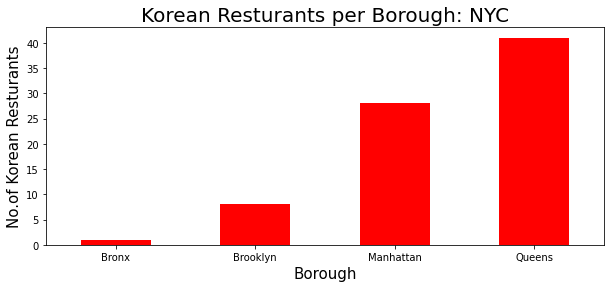

In [ ]:
# Get number of Korean restaurants by Borough

korean_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,4), color = clr)
plt.title('Korean Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Korean Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

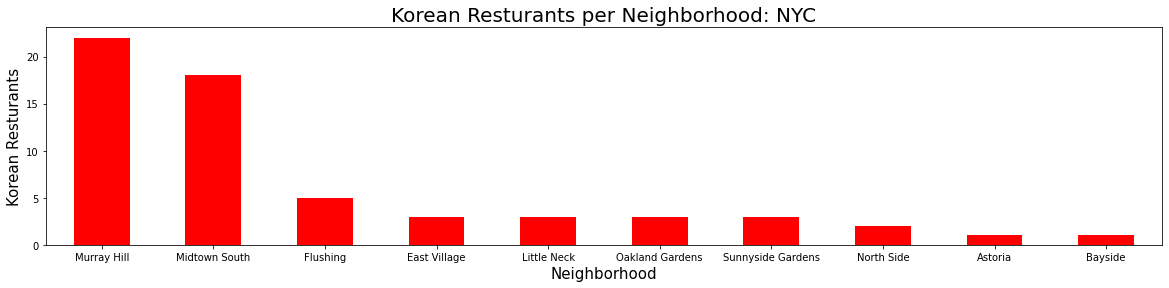

In [ ]:
# Zoom in further: Get number of Korean restaurants in top 10 neighborhoods in NYC and visualize the results to see concentration 

NOofNeigh = 10 
korean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(20,4), color=clr)
plt.title('Korean Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Korean Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
# Get a list of Korean restaurants in Murray Hill 
korean_rest_ny[korean_rest_ny['Neighborhood']=='Murray Hill']

,Borough,Neighborhood,ID,Name
31,Queens,Murray Hill,4b830e44f964a520ebf430e3,Hahm Ji Bach - 함지박
32,Queens,Murray Hill,4b8f0931f964a520d04533e3,Mapo BBQ
33,Queens,Murray Hill,4baeabe6f964a52037cd3be3,Kum Sung Chik Naengmyun
34,Queens,Murray Hill,5590598a498eb1c3f975b6a6,Mr. Tofu
35,Queens,Murray Hill,4c7ad3dda86837048bee144d,Geo Si Gi Restaurant
36,Queens,Murray Hill,5518a1a8498e4c7fe6268b88,Jongro BBQ
37,Queens,Murray Hill,49e10e0bf964a52089611fe3,Mad For Chicken
38,Queens,Murray Hill,56db53cc498eed9b68621019,SGD Tofu House & BBQ
39,Queens,Murray Hill,5cbb9019237dee002cb9f069,Jeong Yook
40,Queens,Murray Hill,4ca67385b7106dcb6e3b5ea5,Bonjuk Korean Traditional Porridge Restaurant


In [ ]:
# Get likes, ratings, and tips data for all the Korean restaurants 

column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
korean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in korean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(korean_rest_ny),')','processed')
    korean_rest_stats_ny = korean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

{'meta': {'code': 200, 'requestId': '5fa5a5e663aa2b1b7ba45466'}, 'response': {'venue': {'id': '4c9d5c0303133704a96f5ed5', 'name': 'Cafe At Your Mother-in-Law', 'contact': {'phone': '7189424088', 'formattedPhone': '(718) 942-4088', 'twitter': 'cafeaymil_ny'}, 'location': {'address': '3071 Brighton 4th St', 'lat': 40.57757524231774, 'lng': -73.96344895612154, 'labeledLatLngs': [{'label': 'display', 'lat': 40.57757524231774, 'lng': -73.96344895612154}, {'label': 'entrance', 'lat': 40.577515, 'lng': -73.963289}], 'postalCode': '11235', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3071 Brighton 4th St', 'Brooklyn, NY 11235', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cafe-at-your-motherinlaw/4c9d5c0303133704a96f5ed5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korea

{'meta': {'code': 200, 'requestId': '5fa5a5e6c3056f1e23f8c5ae'}, 'response': {'venue': {'id': '4fa162e0e4b0badc81404a51', 'name': 'Kimchi Grill', 'contact': {'phone': '7183601839', 'formattedPhone': '(718) 360-1839'}, 'location': {'address': '766 Washington Ave', 'crossStreet': 'btwn Sterling & Park Pl.', 'lat': 40.67512957407338, 'lng': -73.96324476804656, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67512957407338, 'lng': -73.96324476804656}], 'postalCode': '11238', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['766 Washington Ave (btwn Sterling & Park Pl.)', 'Brooklyn, NY 11238', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimchi-grill/4fa162e0e4b0badc81404a51', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5fa5a5e790fd6244ff994291'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5fa5a5e7ec215d40fbfea3da'}, 'response': {'venue': {'id': '59c295349b04732c1d51aa52', 'name': 'Kimbap Lab', 'contact': {'phone': '7187342321', 'formattedPhone': '(718) 734-2321'}, 'location': {'address': '238 Bedford Avenue', 'lat': 40.71616, 'lng': -73.95953, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71616, 'lng': -73.95953}], 'postalCode': '11249', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['238 Bedford Avenue', 'Brooklyn, NY 11249', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kimbap-lab/59c295349b04732c1d51aa52', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '56aa371be4b08b9a8d57350b', 'name': 'Food Stand', 'pluralName': 'Food Stands', 'shortName': 'Food Stand', 'i

{'meta': {'code': 200, 'requestId': '5fa5a5e8d16d0709a739d221'}, 'response': {'venue': {'id': '52bf3053498e754b09a440b5', 'name': 'Dotory', 'contact': {'phone': '7185991399', 'formattedPhone': '(718) 599-1399', 'facebook': '474808822615656', 'facebookUsername': 'dotorybk', 'facebookName': 'Dotory'}, 'location': {'address': '353 Broadway', 'lat': 40.707729602666035, 'lng': -73.95577850789788, 'labeledLatLngs': [{'label': 'display', 'lat': 40.707729602666035, 'lng': -73.95577850789788}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['353 Broadway', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dotory/52bf3053498e754b09a440b5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verifi

{'meta': {'code': 200, 'requestId': '5fa5a5e89d7cfa6c1b9e0940'}, 'response': {'venue': {'id': '59777632a0215b656ce48629', 'name': 'Tofu Tofu', 'contact': {'phone': '2129665306', 'formattedPhone': '(212) 966-5306'}, 'location': {'address': '96 Bowery', 'crossStreet': 'hester', 'lat': 40.717605115822764, 'lng': -73.99530413000093, 'labeledLatLngs': [{'label': 'display', 'lat': 40.717605115822764, 'lng': -73.99530413000093}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['96 Bowery (hester)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tofu-tofu/59777632a0215b656ce48629', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d142941735', 'name': 'Asian Restaurant', 

{'meta': {'code': 200, 'requestId': '5fa5a5e88d464035d6a04dfe'}, 'response': {'venue': {'id': '5dbcafa6e40280000819d3db', 'name': 'Kochi', 'contact': {}, 'location': {'address': '652 10th Ave', 'crossStreet': '46th Street', 'lat': 40.76203, 'lng': -73.99355, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76203, 'lng': -73.99355}], 'postalCode': '10036', 'cc': 'US', 'neighborhood': "Hell's Kitchen", 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['652 10th Ave (46th Street)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kochi/5dbcafa6e40280000819d3db', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'url': 'http://kochinyc.com', 'price': {'tier': 2, 'message': 'Moderat

{'meta': {'code': 200, 'requestId': '5fa5a5e808bd407f2d88df01'}, 'response': {'venue': {'id': '5dec54b8f93ca90007806f97', 'name': 'Mokyo', 'contact': {}, 'location': {'address': '109 Saint Marks Pl', 'lat': 40.727179, 'lng': -73.984056, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727179, 'lng': -73.984056}, {'label': 'entrance', 'lat': 40.727122, 'lng': -73.983949}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['109 Saint Marks Pl', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mokyo/5dec54b8f93ca90007806f97', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {

{'meta': {'code': 200, 'requestId': '5fa5a5e9a97868185a142a3b'}, 'response': {'venue': {'id': '59aa0677e17910245d942204', 'name': 'Jeju Noodle Bar', 'contact': {'phone': '2019213333', 'formattedPhone': '(201) 921-3333', 'instagram': 'jejunoodlebar'}, 'location': {'address': '679 Greenwich St', 'crossStreet': 'at Christopher St', 'lat': 40.73294539559912, 'lng': -74.0073655954149, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73294539559912, 'lng': -74.0073655954149}, {'label': 'entrance', 'lat': 40.733036, 'lng': -74.007344}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['679 Greenwich St (at Christopher St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jeju-noodle-bar/59aa0677e17910245d942204', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net

{'meta': {'code': 200, 'requestId': '5fa5a5e91c176430f146486d'}, 'response': {'venue': {'id': '5c0db9ecbfc6d0002c85e28e', 'name': 'Kal', 'contact': {}, 'location': {'address': '34-05 30th Ave', 'lat': 40.76575, 'lng': -73.91871, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76575, 'lng': -73.91871}], 'postalCode': '11103', 'cc': 'US', 'city': 'Astoria', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['34-05 30th Ave', 'Astoria, NY 11103', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kal/5c0db9ecbfc6d0002c85e28e', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 4}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 14, 'groups': [{'type': 'others', 'count': 14, 'items': []}], 'summar

{'meta': {'code': 200, 'requestId': '5fa5a5ea3f73b979169fc558'}, 'response': {'venue': {'id': '4aa5ae46f964a520264920e3', 'name': 'KumGangSan', 'contact': {'phone': '7184610909', 'formattedPhone': '(718) 461-0909'}, 'location': {'address': '13828 Northern Blvd', 'crossStreet': 'btwn Union St & Bowne St', 'lat': 40.763804403940526, 'lng': -73.82714310018443, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763804403940526, 'lng': -73.82714310018443}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13828 Northern Blvd (btwn Union St & Bowne St)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kumgangsan/4aa5ae46f964a520264920e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'ver

{'meta': {'code': 200, 'requestId': '5fa5a5eaa106903c940b8d08'}, 'response': {'venue': {'id': '4ba56790f964a520ca0339e3', 'name': 'Janchi Janchi', 'contact': {}, 'location': {'address': '138-28 Northern Blvd', 'lat': 40.76380109793378, 'lng': -73.82729769969163, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76380109793378, 'lng': -73.82729769969163}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['138-28 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/janchi-janchi/4ba56790f964a520ca0339e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count':

{'meta': {'code': 200, 'requestId': '5fa5a5ebbd28c54ba28a1162'}, 'response': {'venue': {'id': '5b3badba3731ee002cc9e31a', 'name': 'Rolly', 'contact': {'phone': '7182290110', 'formattedPhone': '(718) 229-0110'}, 'location': {'address': '252-01 Northern Blvd', 'lat': 40.769881, 'lng': -73.736461, 'labeledLatLngs': [{'label': 'display', 'lat': 40.769881, 'lng': -73.736461}, {'label': 'entrance', 'lat': 40.769925, 'lng': -73.736396}], 'postalCode': '11362', 'cc': 'US', 'neighborhood': 'Little Neck', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-01 Northern Blvd', 'New York, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/rolly/5b3badba3731ee002cc9e31a', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1c7

{'meta': {'code': 200, 'requestId': '5fa5a5eb524ab44c02e4eb87'}, 'response': {'venue': {'id': '4c71ac6dad69b60c49ac81b9', 'name': 'Taeneung', 'contact': {'phone': '7186313636', 'formattedPhone': '(718) 631-3636'}, 'location': {'address': '248-25 northen Blvd', 'lat': 40.767535, 'lng': -73.73851195, 'labeledLatLngs': [{'label': 'display', 'lat': 40.767535, 'lng': -73.73851195}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['248-25 northen Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/taeneung/4c71ac6dad69b60c49ac81b9', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '

{'meta': {'code': 200, 'requestId': '5fa5a5ec1c176430f14651cd'}, 'response': {'venue': {'id': '4c8adb923dc2a1cda816b132', 'name': 'Bi Won Korean Restaurant', 'contact': {'phone': '7182244585', 'formattedPhone': '(718) 224-4585'}, 'location': {'address': '61-58 Springfield Blvd', 'lat': 40.74749115523934, 'lng': -73.75594447104575, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74749115523934, 'lng': -73.75594447104575}], 'postalCode': '11364', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['61-58 Springfield Blvd', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bi-won-korean-restaurant/4c8adb923dc2a1cda816b132', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'B

{'meta': {'code': 200, 'requestId': '5fa5a5ec25140448611daed9'}, 'response': {'venue': {'id': '4b830e44f964a520ebf430e3', 'name': 'Hahm Ji Bach - 함지박', 'contact': {'phone': '7184609289', 'formattedPhone': '(718) 460-9289'}, 'location': {'address': '40-11 149th Pl', 'lat': 40.763021787852146, 'lng': -73.81504155699612, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763021787852146, 'lng': -73.81504155699612}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-11 149th Pl', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hahm-ji-bach--%ED%95%A8%EC%A7%80%EB%B0%95/4b830e44f964a520ebf430e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BB

{'meta': {'code': 200, 'requestId': '5fa5a5ec63aa2b1b7ba4719c'}, 'response': {'venue': {'id': '4b8f0931f964a520d04533e3', 'name': 'Mapo BBQ', 'contact': {'phone': '7188868292', 'formattedPhone': '(718) 886-8292'}, 'location': {'address': '14924 41st Ave', 'crossStreet': 'at 149th Pl', 'lat': 40.76230926747885, 'lng': -73.81487967625917, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76230926747885, 'lng': -73.81487967625917}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['14924 41st Ave (at 149th Pl)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mapo-bbq/4b8f0931f964a520d04533e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ

{'meta': {'code': 200, 'requestId': '5fa5a5ed8d464035d6a061fa'}, 'response': {'venue': {'id': '5590598a498eb1c3f975b6a6', 'name': 'Mr. Tofu', 'contact': {'phone': '3475060797', 'formattedPhone': '(347) 506-0797'}, 'location': {'address': '152-22 Northern Blvd', 'lat': 40.76484061391216, 'lng': -73.81226649660726, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76484061391216, 'lng': -73.81226649660726}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['152-22 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-tofu/5590598a498eb1c3f975b6a6', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 2, 'message': 'M

{'meta': {'code': 200, 'requestId': '5fa5a5ed6efe695f20894c87'}, 'response': {'venue': {'id': '5518a1a8498e4c7fe6268b88', 'name': 'Jongro BBQ', 'contact': {}, 'location': {'address': '15514 Roosevelt Ave', 'lat': 40.7641127882201, 'lng': -73.8094035270143, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7641127882201, 'lng': -73.8094035270143}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15514 Roosevelt Ave', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jongro-bbq/5518a1a8498e4c7fe6268b88', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 50, 'groups

{'meta': {'code': 200, 'requestId': '5fa5a5ed05f37a5e97941cb2'}, 'response': {'venue': {'id': '49e10e0bf964a52089611fe3', 'name': 'Mad For Chicken', 'contact': {'phone': '7183213818', 'formattedPhone': '(718) 321-3818', 'facebook': '108504405874422', 'facebookUsername': 'MadForChickenNY', 'facebookName': 'Mad For Chicken'}, 'location': {'address': '15718 Northern Blvd', 'crossStreet': 'btwn 157th & 158th St', 'lat': 40.76342579479461, 'lng': -73.80772377497605, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76342579479461, 'lng': -73.80772377497605}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['15718 Northern Blvd (btwn 157th & 158th St)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mad-for-chicken/49e10e0bf964a52089611fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {

{'meta': {'code': 200, 'requestId': '5fa5a5ee182d05230be83cbc'}, 'response': {'venue': {'id': '5cbb9019237dee002cb9f069', 'name': 'Jeong Yook', 'contact': {'phone': '7188868646', 'formattedPhone': '(718) 886-8646'}, 'location': {'address': '152-12 Northern Blvd', 'lat': 40.764801, 'lng': -73.812489, 'labeledLatLngs': [{'label': 'display', 'lat': 40.764801, 'lng': -73.812489}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['152-12 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jeong-yook/5cbb9019237dee002cb9f069', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralName': 'BBQ Joints', 'shortName': 'BBQ', 'ic

{'meta': {'code': 200, 'requestId': '5fa5a5ee0bf98854152e16bf'}, 'response': {'venue': {'id': '4ad3bfabf964a52016e620e3', 'name': 'Han Joo', 'contact': {'phone': '7183596888', 'formattedPhone': '(718) 359-6888'}, 'location': {'address': '41-06 149th Pl', 'crossStreet': 'at 41st Ave', 'lat': 40.762274065368665, 'lng': -73.8147692298185, 'labeledLatLngs': [{'label': 'display', 'lat': 40.762274065368665, 'lng': -73.8147692298185}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41-06 149th Pl (at 41st Ave)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-joo/4ad3bfabf964a52016e620e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 20}, 'p

{'meta': {'code': 200, 'requestId': '5fa5a5ee8c52b7054b86c2d1'}, 'response': {'venue': {'id': '51c612d9498e52a02241e27b', 'name': '병천자매순대 (Byun Chung Soon Dae Restaurant) (Byun Chung Soon Dae Restaurant)', 'contact': {'phone': '7184601044', 'formattedPhone': '(718) 460-1044'}, 'location': {'address': '156-03 Northern Blvd', 'crossStreet': '156th St', 'lat': 40.76423360851895, 'lng': -73.80900947753332, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76423360851895, 'lng': -73.80900947753332}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156-03 Northern Blvd (156th St)', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/%EB%B3%91%EC%B2%9C%EC%9E%90%EB%A7%A4%EC%88%9C%EB%8C%80-byun-chung-soon-dae-restaurant/51c612d9498e52a02241e27b', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'p

{'meta': {'code': 200, 'requestId': '5fa5a5efafd98854dde0bb9f'}, 'response': {'venue': {'id': '58756dc845c3ed5546c88309', 'name': 'Sodam', 'contact': {'phone': '7188861616', 'formattedPhone': '(718) 886-1616'}, 'location': {'address': '156-50 Northern Blvd', 'lat': 40.763867658707134, 'lng': -73.80841950191183, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763867658707134, 'lng': -73.80841950191183}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['156-50 Northern Blvd', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sodam/58756dc845c3ed5546c88309', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'price': {'tier': 2, 'message': 'Mode

{'meta': {'code': 200, 'requestId': '5fa5a5ef08bd407f2d88fba6'}, 'response': {'venue': {'id': '5147a0bce4b09c3bed35c23b', 'name': '큰손 칼국수', 'contact': {}, 'location': {'address': '35-04 154th St', 'lat': 40.76586428971515, 'lng': -73.81090861460873, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76586428971515, 'lng': -73.81090861460873}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['35-04 154th St', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/%ED%81%B0%EC%86%90-%EC%B9%BC%EA%B5%AD%EC%88%98/5147a0bce4b09c3bed35c23b', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'lik

{'meta': {'code': 200, 'requestId': '5fa5a5ef63aa2b1b7ba47fa9'}, 'response': {'venue': {'id': '4d85677302eb5481ee0744f5', 'name': 'Gugongtan', 'contact': {}, 'location': {'address': '40-03 149th Place', 'crossStreet': 'Roosevelt Ave', 'lat': 40.76317994459784, 'lng': -73.81510419142043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76317994459784, 'lng': -73.81510419142043}], 'postalCode': '11354', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['40-03 149th Place (Roosevelt Ave)', 'New York, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/gugongtan/4d85677302eb5481ee0744f5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 2, 'message': 'Moderate', 'c

{'meta': {'code': 200, 'requestId': '5fa5a5f00bf98854152e1f61'}, 'response': {'venue': {'id': '56522cdc498ee09c2f9777d5', 'name': 'Daeji Daeji 돼지되지', 'contact': {'phone': '7188866797', 'formattedPhone': '(718) 886-6797'}, 'location': {'address': '41-08 149th Pl', 'lat': 40.76221186792486, 'lng': -73.81467031272346, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76221186792486, 'lng': -73.81467031272346}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['41-08 149th Pl', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/daeji-daeji-%EB%8F%BC%EC%A7%80%EB%90%98%EC%A7%80/56522cdc498ee09c2f9777d5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1

{'meta': {'code': 200, 'requestId': '5fa5a5f0dc3fa014e6f68099'}, 'response': {'venue': {'id': '540f86da498e020149fa7676', 'name': 'Jongro BBQ', 'contact': {'phone': '2124732233', 'formattedPhone': '(212) 473-2233', 'facebook': '409586342513959', 'facebookUsername': 'jongrobbqny', 'facebookName': 'Jongro BBQ'}, 'location': {'address': '22 W 32nd St Fl 2', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747574, 'lng': -73.987043, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747574, 'lng': -73.987043}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['22 W 32nd St Fl 2 (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jongro-bbq/540f86da498e020149fa7676', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3

{'meta': {'code': 200, 'requestId': '5fa5a5f1edf6b74902a32f57'}, 'response': {'venue': {'id': '49becfd3f964a520e0541fe3', 'name': 'Woorijip', 'contact': {'phone': '2122441115', 'formattedPhone': '(212) 244-1115'}, 'location': {'address': '12 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.7476231963955, 'lng': -73.98637205431945, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7476231963955, 'lng': -73.98637205431945}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Ktown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['12 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/woorijip/49becfd3f964a520e0541fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 've

{'meta': {'code': 200, 'requestId': '5fa5a5f1418d9541e7d6c7c6'}, 'response': {'venue': {'id': '517563f9498e0a4859d08fe4', 'name': 'BCD Tofu House', 'contact': {'phone': '2129671900', 'formattedPhone': '(212) 967-1900', 'twitter': 'bcdtofuhouse'}, 'location': {'address': '5 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747362, 'lng': -73.985663, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747362, 'lng': -73.985663}, {'label': 'entrance', 'lat': 40.747481, 'lng': -73.986046}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bcd-tofu-house/517563f9498e0a4859d08fe4', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_',

{'meta': {'code': 200, 'requestId': '5fa5a5f13f31f81937d472e5'}, 'response': {'venue': {'id': '4a9d3c1af964a520ff3720e3', 'name': 'E-Mo Kimbap', 'contact': {'phone': '2125941466', 'formattedPhone': '(212) 594-1466'}, 'location': {'address': '2 W 32nd St', 'crossStreet': 'btwn 5th Ave & Broadway', 'lat': 40.747264, 'lng': -73.986221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747264, 'lng': -73.986221}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2 W 32nd St (btwn 5th Ave & Broadway)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/emo-kimbap/4a9d3c1af964a520ff3720e3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 42}, 'price': 

{'meta': {'code': 200, 'requestId': '5fa5a5f263aa2b1b7ba489c7'}, 'response': {'venue': {'id': '40bbc700f964a520a2001fe3', 'name': 'New Wonjo', 'contact': {'phone': '2126955815', 'formattedPhone': '(212) 695-5815', 'facebook': '129929267091324', 'facebookUsername': 'newwonjo', 'facebookName': 'New Wonjo Restaurant'}, 'location': {'address': '23 W 32nd St', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.74779978165289, 'lng': -73.98684697596717, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74779978165289, 'lng': -73.98684697596717}, {'label': 'entrance', 'lat': 40.747774, 'lng': -73.986743}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['23 W 32nd St (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/new-wonjo/40bbc700f964a520a2001fe3', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurant

{'meta': {'code': 200, 'requestId': '5fa5a5f2395e5f068300c48b'}, 'response': {'venue': {'id': '547d03e3498eb32c879589da', 'name': 'Baekjeong NYC (Kang Ho Dong Baekjeong)', 'contact': {'phone': '2129669839', 'formattedPhone': '(212) 966-9839', 'twitter': 'baekjeongnyc', 'instagram': 'baekjeongnyc', 'facebook': '425961227537735', 'facebookUsername': 'baekjeongnyc', 'facebookName': 'Kang Ho Dong Baekjeong - Koreatown NYC'}, 'location': {'address': '1 E 32nd St', 'crossStreet': 'at 5th Ave', 'lat': 40.74709879834891, 'lng': -73.98519423416221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74709879834891, 'lng': -73.98519423416221}, {'label': 'entrance', 'lat': 40.747063, 'lng': -73.985067}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Koreatown', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1 E 32nd St (at 5th Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/baekjeong-nyc/547d03e3498eb32c879589da',

{'meta': {'code': 200, 'requestId': '5fa5a5f2a97868185a1453f1'}, 'response': {'venue': {'id': '4c254ba6136d20a19f63e361', 'name': 'miss KOREA BBQ', 'contact': {'phone': '2125944963', 'formattedPhone': '(212) 594-4963', 'twitter': 'misskoreabbq', 'facebook': '135037553209059', 'facebookUsername': 'missKOREABBQ', 'facebookName': 'miss KOREA BBQ'}, 'location': {'address': '10 W 32nd St Fl 3 #1', 'crossStreet': 'btwn Broadway & 5th Ave', 'lat': 40.747286, 'lng': -73.98641, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747286, 'lng': -73.98641}, {'label': 'entrance', 'lat': 40.747426, 'lng': -73.986378}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10 W 32nd St Fl 3 #1 (btwn Broadway & 5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/miss-korea-bbq/4c254ba6136d20a19f63e361', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': '

{'meta': {'code': 200, 'requestId': '5fa5a5f3561497763b071931'}, 'response': {'venue': {'id': '57180219498e1588034bf6aa', 'name': 'Barn Joo 35', 'contact': {'phone': '2125644430', 'formattedPhone': '(212) 564-4430', 'facebook': '256034814744603', 'facebookUsername': 'barnjoo35', 'facebookName': 'Barn Joo 35'}, 'location': {'address': '34 W 35th St', 'crossStreet': 'btw 5th & 6th Ave', 'lat': 40.74986935743821, 'lng': -73.98589156679648, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74986935743821, 'lng': -73.98589156679648}], 'postalCode': '10001', 'cc': 'US', 'neighborhood': 'Midtown Manhattan, New York, NY', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['34 W 35th St (btw 5th & 6th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/barn-joo-35/57180219498e1588034bf6aa', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean'

{'meta': {'code': 200, 'requestId': '5fa5a5f3c0877943bc325874'}, 'response': {'venue': {'id': '5b857af5b77c77002c2fb242', 'name': 'Hortus', 'contact': {'phone': '6468583784', 'formattedPhone': '(646) 858-3784'}, 'location': {'address': '271 5th Ave', 'crossStreet': 'b/t 30th St & 29th St', 'lat': 40.74551921832626, 'lng': -73.98658183981865, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74551921832626, 'lng': -73.98658183981865}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['271 5th Ave (b/t 30th St & 29th St)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hortus/5b857af5b77c77002c2fb242', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCou

{'meta': {'code': 200, 'requestId': '5fa5a5f4349fac21583af3ab'}, 'response': {'venue': {'id': '4dc9923322717adb0377893e', 'name': 'Nolbu', 'contact': {'phone': '7189397374', 'formattedPhone': '(718) 939-7374'}, 'location': {'address': '164 Northern Blvd.', 'lat': 40.72976244180187, 'lng': -73.79899631467974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72976244180187, 'lng': -73.79899631467974}], 'postalCode': '11355', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['164 Northern Blvd.', 'Fresh Meadows, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/nolbu/4dc9923322717adb0377893e', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 2, 'message': '

{'meta': {'code': 200, 'requestId': '5fa5a5f4dc3fa014e6f692ef'}, 'response': {'venue': {'id': '4c0c2765a1b32d7f49279cf0', 'name': 'Sik Gaek', 'contact': {'phone': '7182054555', 'formattedPhone': '(718) 205-4555'}, 'location': {'address': '49-11 Roosevelt Ave', 'lat': 40.743321709056595, 'lng': -73.9153360823082, 'labeledLatLngs': [{'label': 'display', 'lat': 40.743321709056595, 'lng': -73.9153360823082}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['49-11 Roosevelt Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sik-gaek/4c0c2765a1b32d7f49279cf0', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d116941735', 'name': 'Bar', 'pluralName': 'Bars', 'shortNam

{'meta': {'code': 200, 'requestId': '5fa5a5f5c3056f1e23f90785'}, 'response': {'venue': {'id': '5630104d498e08f2c7217877', 'name': 'Doma', 'contact': {'phone': '7187070615', 'formattedPhone': '(718) 707-0615'}, 'location': {'address': '43-43 41st St', 'lat': 40.7441709860382, 'lng': -73.92319233354881, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7441709860382, 'lng': -73.92319233354881}], 'postalCode': '11104', 'cc': 'US', 'neighborhood': 'Sunnyside', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['43-43 41st St', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/doma/5630104d498e08f2c7217877', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 2, 'mess

{'meta': {'code': 200, 'requestId': '5fa5a5f5dc3fa014e6f69615'}, 'response': {'venue': {'id': '4be747b7bcef2d7fdb1b06e5', 'name': 'KBBQ', 'contact': {}, 'location': {'address': '119 W Kingsbridge Rd', 'lat': 40.868843, 'lng': -73.90195600000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.868843, 'lng': -73.90195600000001}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['119 W Kingsbridge Rd', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kbbq/4be747b7bcef2d7fdb1b06e5', 'categories': [{'id': '4bf58dd8d48988d113941735', 'name': 'Korean Restaurant', 'pluralName': 'Korean Restaurants', 'shortName': 'Korean', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/korean_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 0, 'groups': []}, 'dislike': False, 'ok

In [ ]:
korean_rest_stats_ny.tail()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
73,Manhattan,Flatiron,591cdaf26f0aa22c76a53ff3,Cote,251,8.3,58
74,Queens,Sunnyside Gardens,4c0c2765a1b32d7f49279cf0,Sik Gaek,79,8.1,42
75,Queens,Sunnyside Gardens,57ab54da498e7d61e0c1fe0e,Pelicana Chicken,24,7.2,7
76,Queens,Sunnyside Gardens,5630104d498e08f2c7217877,Doma,16,7.0,6
77,Bronx,Kingsbridge Heights,0,0,0,0.0,0


In [ ]:
korean_rest_stats_ny.to_csv('korean_rest_stats_ny_csv.csv') # I continue to save data to a .csv as I move through this project

In [ ]:
korean_rest_stats_ny.shape

(78, 7)

In [ ]:
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       78 non-null     object 
 1   Neighborhood  78 non-null     object 
 2   ID            78 non-null     object 
 3   Name          78 non-null     object 
 4   Likes         78 non-null     object 
 5   Rating        78 non-null     float64
 6   Tips          78 non-null     object 
dtypes: float64(1), object(6)
memory usage: 4.4+ KB


In [ ]:
korean_rest_stats_ny['Likes'] = korean_rest_stats_ny['Likes'].astype('float64')
korean_rest_stats_ny['Tips'] = korean_rest_stats_ny['Tips'].astype('float64')
korean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       78 non-null     object 
 1   Neighborhood  78 non-null     object 
 2   ID            78 non-null     object 
 3   Name          78 non-null     object 
 4   Likes         78 non-null     float64
 5   Rating        78 non-null     float64
 6   Tips          78 non-null     float64
dtypes: float64(3), object(4)
memory usage: 4.4+ KB


In [ ]:
korean_rest_stats_ny.describe()

,Likes,Rating,Tips
count,78.000000,78.000000,78.000000
mean,157.038462,6.976923,41.961538
std,260.096508,2.655302,61.311307
min,0.000000,0.000000,0.000000
25%,10.250000,6.925000,3.000000
50%,26.000000,7.900000,8.500000
75%,177.000000,8.400000,57.500000
max,1228.000000,9.200000,283.000000


In [ ]:
# Resturant with maximum Likes
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              517563f9498e0a4859d08fe4
Name                      BCD Tofu House
Likes                               1228
Rating                               8.9
Tips                                 205
Name: 58, dtype: object

In [ ]:
# Resturant with maximum Ratings
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              540f86da498e020149fa7676
Name                          Jongro BBQ
Likes                                848
Rating                               9.2
Tips                                 158
Name: 54, dtype: object

In [ ]:
# Resturant with maximum Tips
korean_rest_stats_ny.iloc[korean_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood               Midtown South
ID              49becfd3f964a520e0541fe3
Name                            Woorijip
Likes                                929
Rating                               8.4
Tips                                 283
Name: 56, dtype: object

In [ ]:
ny_neighborhood_stats=korean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
7,East Village,8.900000
23,Tribeca,8.900000
4,Civic Center,8.900000
18,Park Slope,8.900000
14,Midtown South,8.483333
0,Astoria,8.400000
19,Prospect Heights,8.400000
13,Manhattan Valley,8.400000
8,Flatiron,8.300000
5,Clinton,8.300000


In [ ]:
ny_borough_stats=korean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.507143
1,Brooklyn,7.900000
3,Queens,5.921951
0,Bronx,0.000000


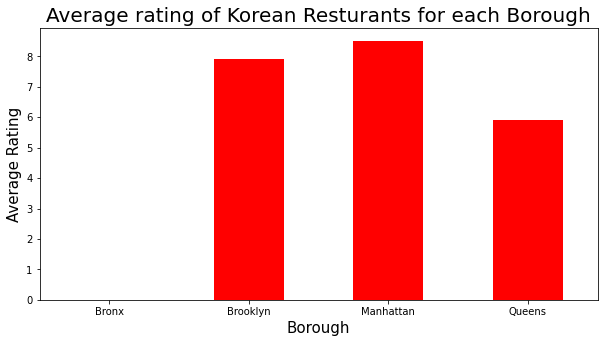

In [ ]:
korean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Korean Resturants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [ ]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Astoria,8.400000
4,Civic Center,8.900000
5,Clinton,8.300000
7,East Village,8.900000
8,Flatiron,8.300000
13,Manhattan Valley,8.400000
14,Midtown South,8.483333
16,North Side,8.050000
18,Park Slope,8.900000
19,Prospect Heights,8.400000


In [ ]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.400000
1,Manhattan,Civic Center,40.715229,-74.005415,8.900000
2,Manhattan,Clinton,40.759101,-73.996119,8.300000
3,Manhattan,East Village,40.727847,-73.982226,8.900000
4,Manhattan,Flatiron,40.739673,-73.990947,8.300000
5,Manhattan,Manhattan Valley,40.797307,-73.964286,8.400000
6,Manhattan,Midtown South,40.748510,-73.988713,8.483333
7,Brooklyn,North Side,40.714823,-73.958809,8.050000
8,Brooklyn,Park Slope,40.672321,-73.977050,8.900000
9,Brooklyn,Prospect Heights,40.676822,-73.964859,8.400000


In [ ]:
# create map 
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [ ]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)